In [2]:
# %% [markdown]
"""
# Analysis of Parallel ACO Experiment Results

This notebook reads the aggregated CSV reports from our ParallelExperiment runs and produces line plots to analyze how the solution quality (best fitness) and runtime change when varying:
1. The number of ants (with fixed batch size)
2. The batch size (with fixed number of ants)

We also include a basic trade-off analysis plot for each experiment.
"""

# %% Import Libraries
import pandas as pd
import matplotlib.pyplot as plt

## Load Aggregated Results

We load the two aggregated CSV files:
- One for varying number of ants ("experiment_varying_ants_summary.csv")
- One for varying batch size ("experiment_varying_batch_size_summary.csv")


In [3]:
sen_small = pd.read_csv("data/sen.small.summary.csv")
sen_medium = pd.read_csv("data/sen.medium.summary.csv")
sen_large = pd.read_csv("data/sen.large.summary.csv")
sen_small.sample(5)

,param_name,param_value,runtime_dvt,cost_dvt,num_instances
0,m,1.00,-54.659489,0.716741,5
11,alpha,1.00,4.269414,-0.036182,5
2,m,6.00,54.340492,-0.018040,5
17,beta,1.25,-7.101556,0.328744,5
34,LS,90.00,-11.186704,0.332061,5


In [4]:
parameters = sen_small["param_name"].unique()
parameters

array(['m', 'I', 'alpha', 'beta', 'rho', 'Q', 'LS', 't'], dtype=object)

In [ ]:
# Per-parameter deviation plots: 2-column grid, each subplot is one parameter
import math
import yaml

def sen_plot(sen_df: pd.DataFrame, size: str = "small"):
    # Load default parameters from YAML file
    with open("data/paco.tune.yaml", "r") as f:
        tune_config = yaml.safe_load(f)
    param_config = tune_config.get(size, {})
    defaults = {param: config["default"] for param, config in param_config.items()}
    
    # Add default parameter values to the dataframe with runtime_dvt and cost_dvt = 0
    default_rows = []
    for param, default_val in defaults.items():
        if param in sen_df['param_name'].values:
            # Check if default value already exists in the data
            existing = sen_df[(sen_df['param_name'] == param) & (sen_df['param_value'].astype(str) == str(default_val))]
            if existing.empty:
                default_rows.append({
                    'param_name': param,
                    'param_value': default_val,
                    'runtime_dvt': 0.0,
                    'cost_dvt': 0.0,
                    'num_instances': 5
                })
    if default_rows:
        sen_df = pd.concat([sen_df, pd.DataFrame(default_rows)], ignore_index=True)
    
    # Define parameters list (ordered) – intersection with data to avoid missing ones
    param_list = sen_df["param_name"].unique()
    available = set(sen_df['param_name'].unique())
    parameters_to_plot = [p for p in param_list if p in available]
    if not parameters_to_plot:
        raise ValueError("None of the specified parameters found in the dataset.")

    # Detect if deviation values are proportions (<= ~1) and scale to percentage
    max_dev = max(sen_df['runtime_dvt'].max(), sen_df['cost_dvt'].max())
    scale = 100 if max_dev <= 1.2 else 1

    n = len(parameters_to_plot)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]

    legend_handles = None
    legend_labels = None

    for i, param in enumerate(parameters_to_plot):
        ax = axes[i]
        sub = sen_df[sen_df['param_name'] == param].copy()
        # Convert param_value to numeric if possible for sorting
        sub['param_value_num'] = pd.to_numeric(sub['param_value'], errors='coerce')
        # Sort by numeric where available else fallback to original order
        if sub['param_value_num'].notna().any():
            sub = sub.sort_values('param_value_num')
            x_vals = sub['param_value_num']
        else:
            x_vals = sub['param_value']
        runtime_vals = sub['runtime_dvt'] * scale
        cost_vals = sub['cost_dvt'] * scale

        line1, = ax.plot(x_vals, runtime_vals, marker='o', linestyle='-', color='tab:blue', label='Runtime Dev')
        line2, = ax.plot(x_vals, cost_vals, marker='s', linestyle='--', color='tab:red', label='Cost Dev')

        if legend_handles is None:
            legend_handles = [line1, line2]
            legend_labels = ['Runtime Dev', 'Cost Dev']

        # Get parameter config for title annotation
        pconfig = param_config.get(param, {})
        default_x = pconfig.get("default")
        # Draw vertical line at default parameter from YAML config
        if default_x is not None:
            ax.axvline(x=default_x, color='green', linestyle=':', linewidth=1.5, alpha=0.7)
            # Add text annotation with default value below the title
            ax.annotate(f'default={default_x:.2f}', xy=(default_x, 1), xycoords=('data', 'axes fraction'),
                        xytext=(0, -5), textcoords='offset points',
                        ha='center', va='top', fontsize=14, color='green')

        # Build title with range and steps info
        title_str = f"{param}"
        ax.set_title(title_str, fontsize=16)
        # ax.set_xlabel("Value", fontsize=14)
        if i % cols == 0:
            ax.set_ylabel(f"%", fontsize=16)
        ax.grid(alpha=0.3)
        
        # Set categorical tick labels, always filtering out default value
        if sub['param_value_num'].notna().any():
            # Filter out default tick
            if default_x is not None:
                filtered_x_vals = [x for x in x_vals if x != default_x]
            else:
                filtered_x_vals = list(x_vals)
            ax.set_xticks(filtered_x_vals)
            # ax.set_xticklabels(filtered_x_ticks, rotation=90, ha='right')
        else:
            ax.tick_params(axis='x', rotation=90)
        
        # Set y-ticks for coherent measure
        ax.set_yticks([-50, 0, 50, 100])

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Increase tick label font sizes for all axes
    for ax in axes:
        if ax is not None and ax.get_visible():
            ax.tick_params(axis='both', labelsize=14)

    # fig.suptitle("Runtime & Cost Deviation by Parameter Value", fontsize=14, y=0.995)
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    # Single shared legend
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, 1.02),
        fontsize=16,
        title_fontsize=16
    )
    plt.show()

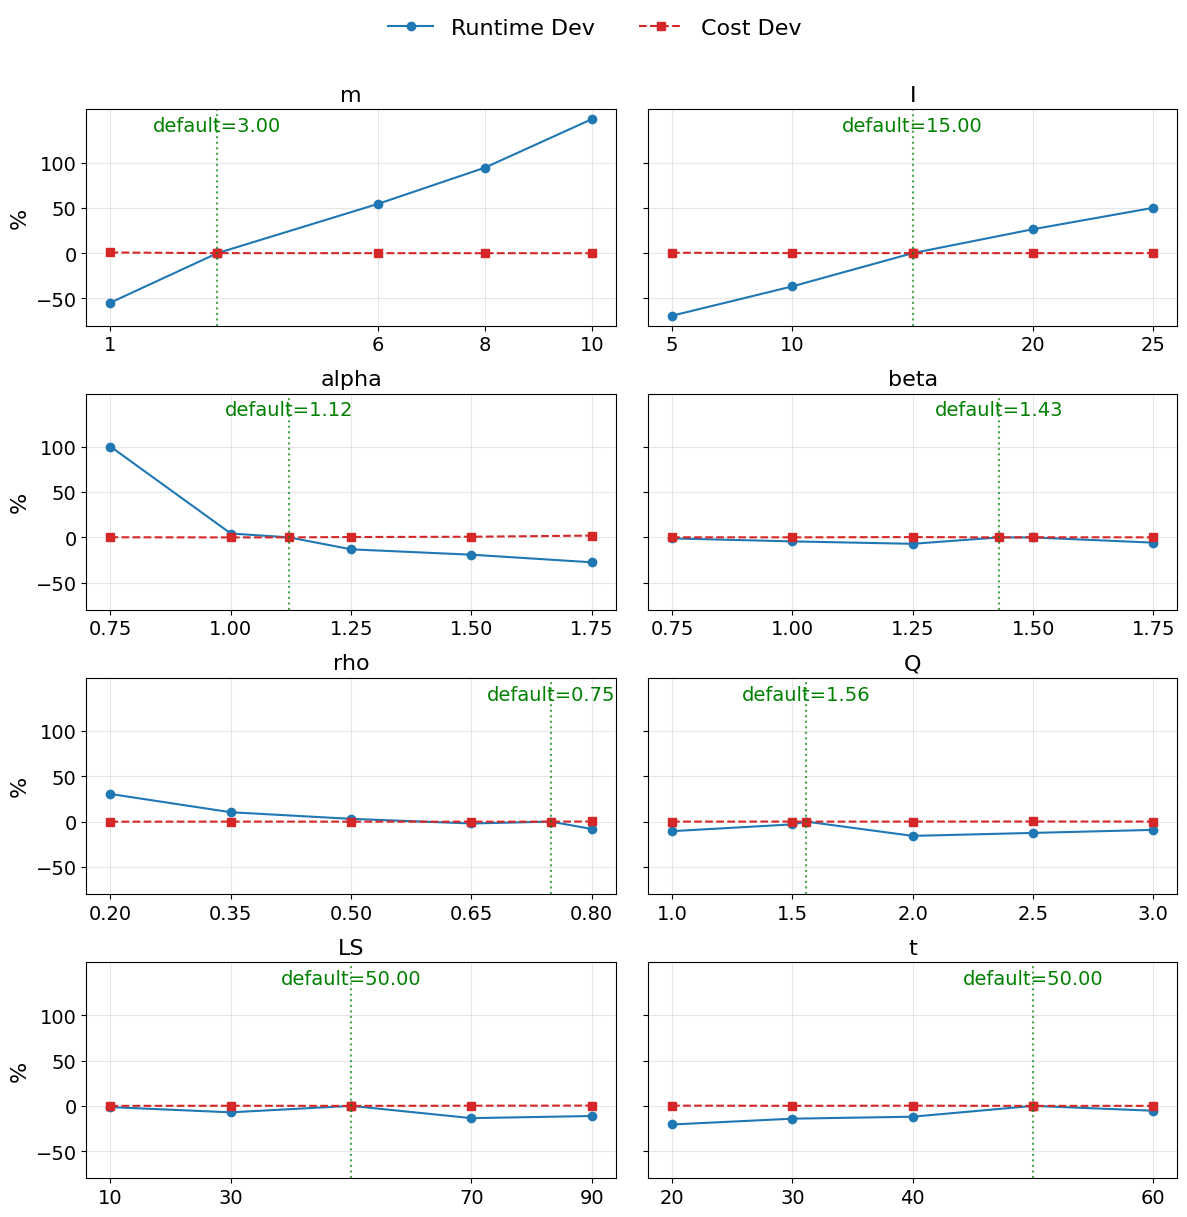

In [45]:
sen_plot(sen_small, size="small")